In [1]:
# Pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib
%pylab inline

# seaborn 
import seaborn as sns
sns.set_style('whitegrid')

# macchine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Populating the interactive namespace from numpy and matplotlib


## 1. Load and check data

In [2]:
# get titanic train & test csv files as DataFrames
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_df.info()
print '-----------------------------------------'
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-nul

| Variable Name | Description                       |
|---------------|-----------------------------------|
| Survived      | Survived(1) or died (0)           |
| Pclass        | Passenger’s class                 |
| Name          | Passenger’s name                  |
| Sex           | Passenger’s sex                   |
| Age           | Passenger’s age                   |
| SibSp         | Number of siblings/spouses aboard |
| Parch         | Number of parents/children aboard |
| Ticket        | Ticket number                     |
| Fare          | Fare                              |
| Cabin         | Cabin                             |
| Embarked      | Port of embarkation               |

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis
# and prediction

train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis=1)

1. Embarked
============

In [6]:
# only in the train_df, fill the two missing values with the most occurred
# value which is "S".

train_df["Embarked"] = train_df["Embarked"].fillna("S")

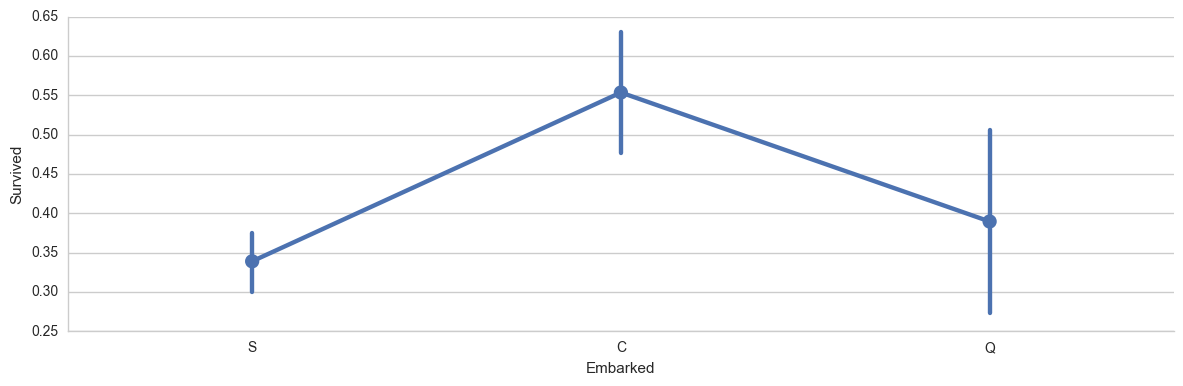

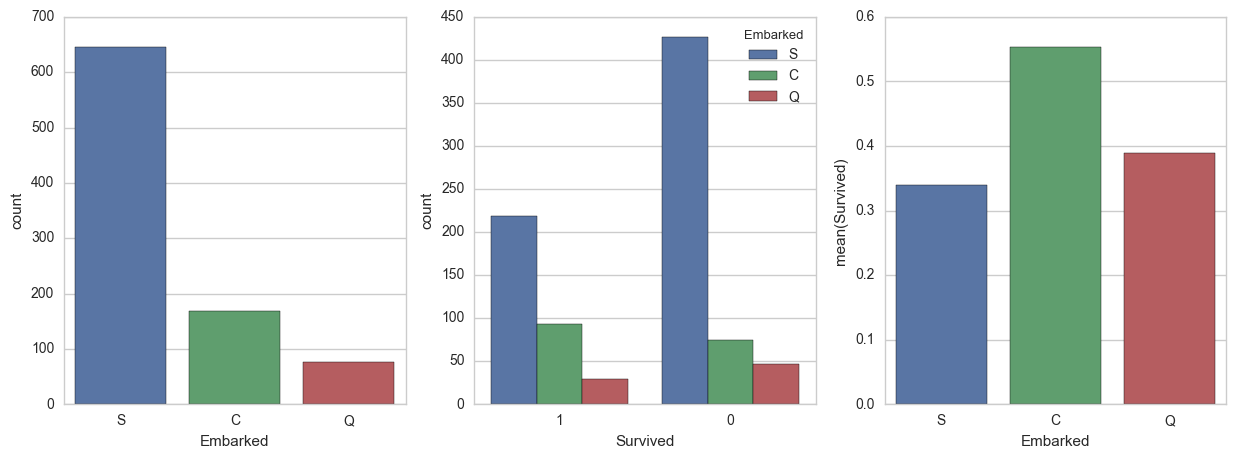

In [14]:
# plot
sns.factorplot('Embarked', 'Survived', data=train_df, size=4, aspect=3)
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(15,5))

sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue='Embarked', data=train_df, order=[1,0],
             ax=axis2)

# group by embarked, and get the mean for survived passengers for each value
# in Embarked

embark_perc = train_df[['Embarked', 'Survived']].groupby(['Embarked'], 
                                                         as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc, 
            order=['S', 'C', 'Q'], ax=axis3)
plt.show()

In [16]:

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_train  = pd.get_dummies(train_df['Embarked'])
embark_dummies_train.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_train)
test_df    = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

2. Fare
============

In [24]:
# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = train_df["Fare"][train_df["Survived"] == 0]
fare_survived = train_df["Fare"][train_df["Survived"] == 1]


# get average and std for fare of survived/not survived passengers
average_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

In [28]:
print average_fare
print std_fare

           0
0  21.690346
1  47.991228
           0
0  31.392229
1  66.608322


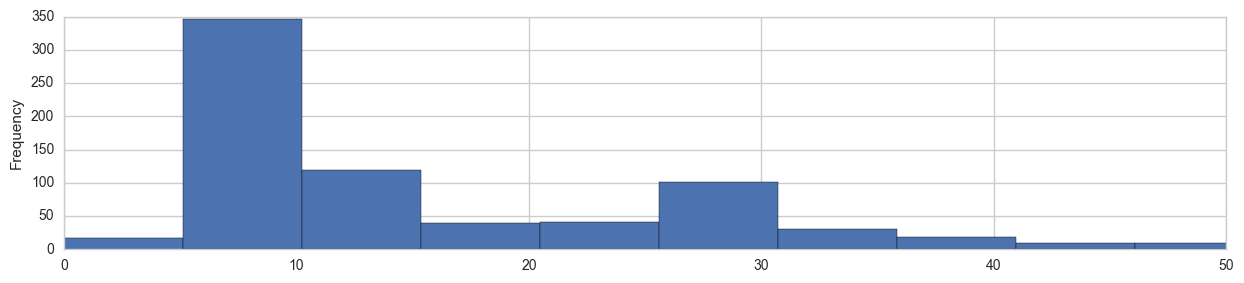

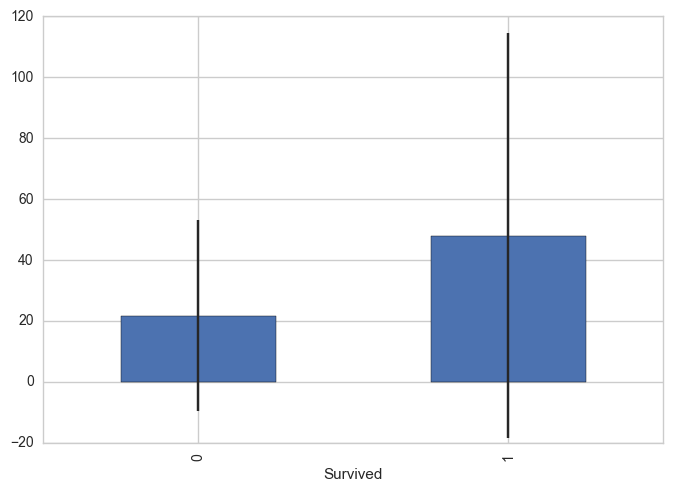

In [33]:
# plot 
train_df['Fare'].plot(kind='hist', figsize=(15,3), bins=100, xlim=(0,50))
average_fare.index.names = std_fare.index.names = ["Survived"]
average_fare.plot(yerr=std_fare, kind='bar', legend=False)
plt.show()

3. Age
=============

C:\Users\qubit\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\qubit\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


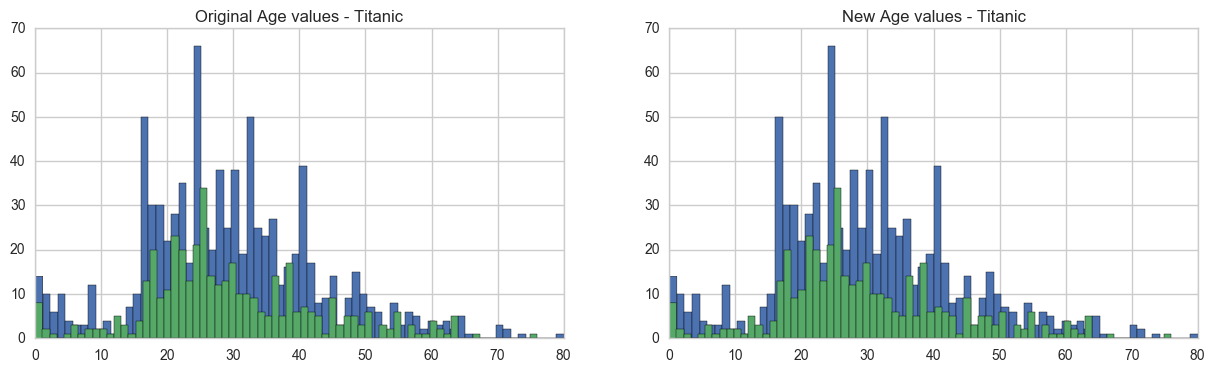

In [45]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in train_df
average_age_train   = train_df["Age"].mean()
std_age_train       = train_df["Age"].std()
count_nan_age_train = train_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_train - std_age_train, 
                           average_age_train + std_age_train,
                          size = count_nan_age_train)
rand_2 = np.random.randint(average_age_test - std_age_test,
                          average_age_test + std_age_test,
                          size = count_nan_age_test)

# Plot original Age values
# Drop all null values, and convert to int
train_df["Age"].dropna().astype(int).hist(bins=70, ax=axis1)
test_df["Age"].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_df["Age"][np.isnan(train_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)


# Plot new Age Values
train_df['Age'].hist(bins=70, ax=axis2)
test_df['Age'].hist(bins=70, ax=axis2)
plt.show()

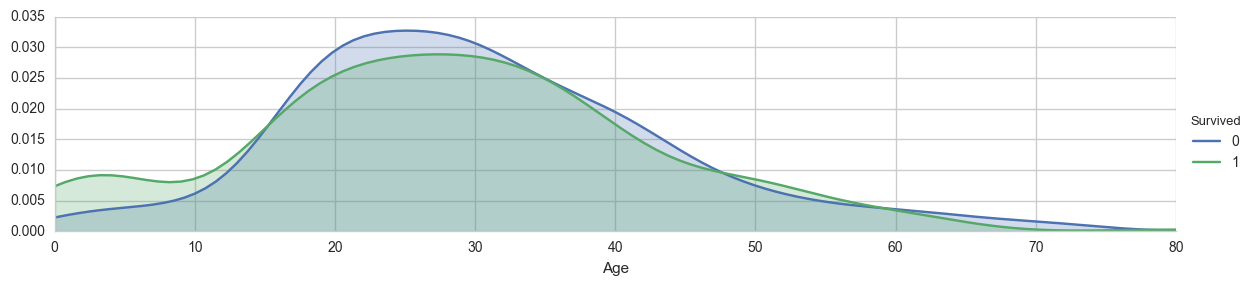

In [51]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

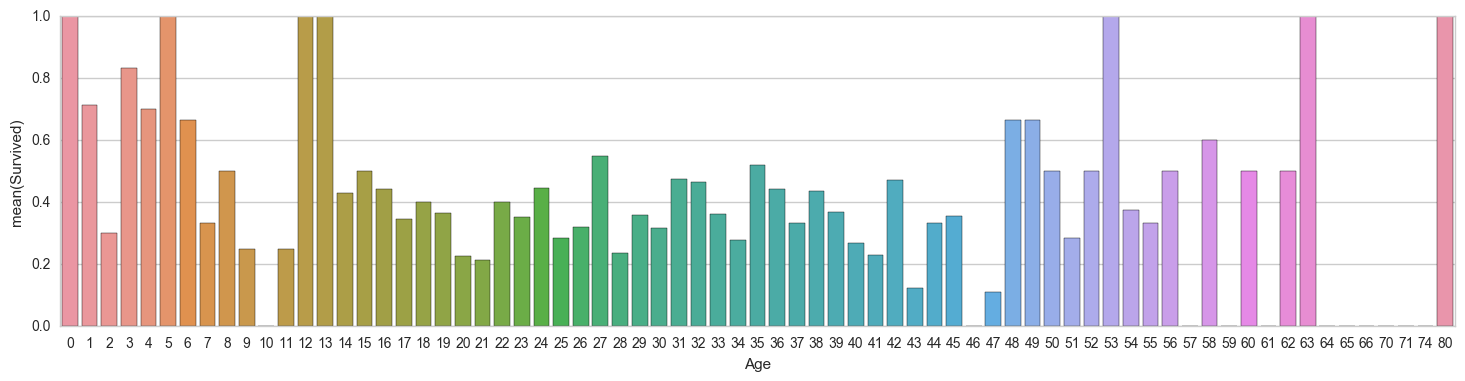

In [53]:
# average survived passengers by age
fig, axis1 = plt.subplots(1,1, figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'], 
                                                    as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)
plt.show()

4. Cabin
================
It has a lot of NaN values, so it won't cause a remarkable impact on prediction

In [54]:
train_df.drop("Cabin", axis=1, inplace=True)
test_df.drop("Cabin", axis=1, inplace=True)

5. Family
==============
- Instead of having two colums Parch & SibSp, we can have only one column represent if the passenger had only family member onboard or not, meaning, if having any family member(whether parent, brother, ... etc) will increase chances of survival or not.

In [59]:
train_df['Family'] = train_df['Parch'] + train_df['SibSp']
train_df['Family'].loc[train_df['Family'] > 0] = 1
train_df['Family'].loc[train_df['Family'] == 0] = 0


test_df['Family'] = test_df['Parch'] + test_df['SibSp']
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

In [60]:
# drop Parch & SibSp
train_df  = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df   = test_df.drop(['SibSp', 'Parch'], axis=1)

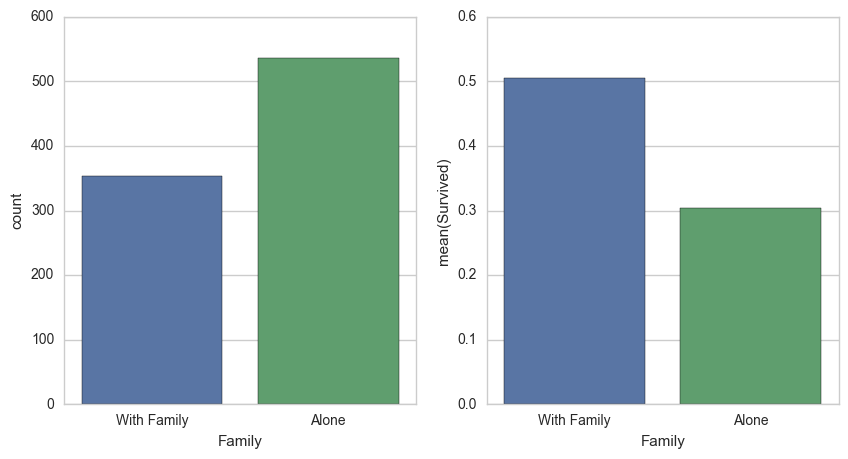

In [69]:
# Plot
fig, (axis1, axis2) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

#sns.factorplot('Family', data=train_df, kind='count', ax=axis1)
sns.countplot(x='Family', data=train_df, order=[1, 0], ax=axis1)


# average of survived for those who had/didn't have any family member
family_perc = train_df[['Family', 'Survived']].groupby(['Family'], 
                                                       as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(['With Family', 'Alone'], rotation=0)
plt.show()

6. Sex
================
- As we see, children (age < ~ 16) on board seem to have a high chance for survival
- so, we can classify passengers as males, females, and child


In [70]:
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

train_df['Person'] = train_df[['Age', 'Sex']].apply(get_person, axis=1)
test_df['Person']  = test_df[['Age', 'Sex']].apply(get_person, axis=1)

In [71]:
# No need to use Sex column since we created Person Column
train_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)

In [73]:
# create dummy variables for Person Column, & drop Male as it has the lowest
# average of survived passengers

person_dummies_train = pd.get_dummies(train_df['Person'])
person_dummies_train.columns = ['Child', 'Female', 'Male']
person_dummies_train.drop(['Male'], axis=1, inplace=True)


person_dummies_test = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child', 'Female', 'Male']
person_dummies_test.drop(['Male'] , axis=1, inplace=True)

train_df = train_df.join(person_dummies_train)
test_df  = test_df.join(person_dummies_test)


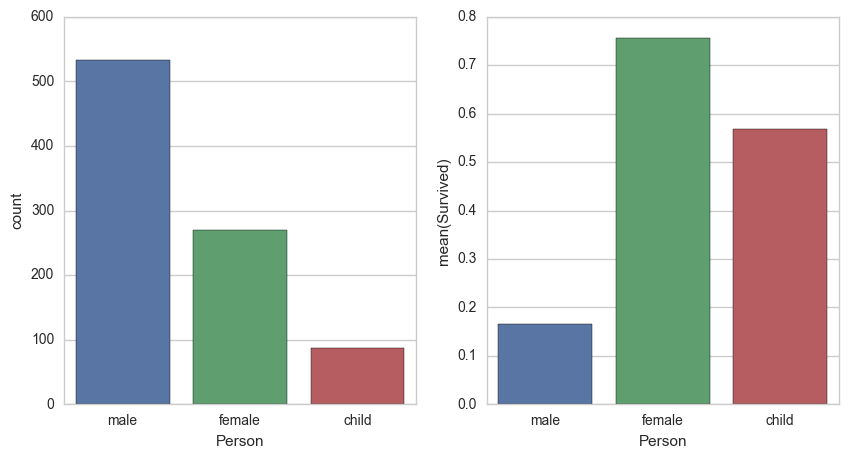

In [78]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(10, 5))

#sns.factorplot('Person', data=train_df, kind='count', ax=axis1)
sns.countplot('Person', data=train_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = train_df[['Person', 'Survived']].groupby(['Person'],
                                                      as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2,
           order=['male', 'female', 'child'])


train_df.drop(['Person'], axis=1, inplace=True)
test_df.drop(['Person'], axis=1, inplace=True)

plt.show()


7. Pclass
=============


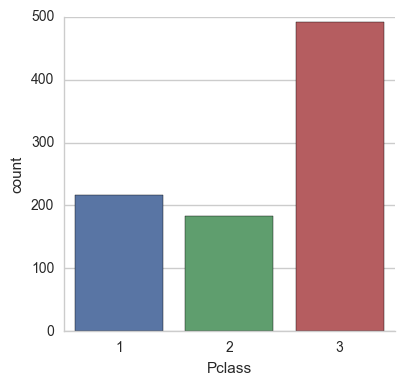

In [79]:
sns.factorplot('Pclass', data=train_df, kind='count', order=[1,2,3])

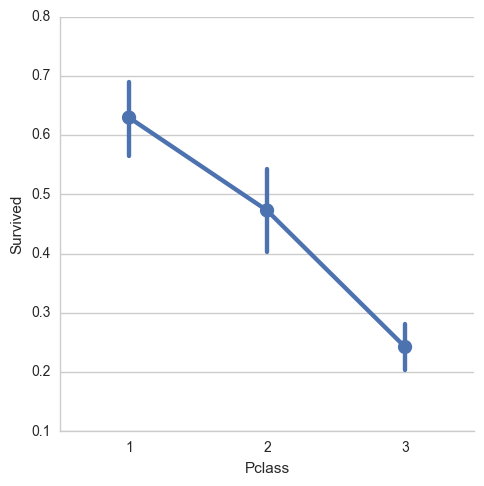

In [80]:
sns.factorplot('Pclass', 'Survived', order=[1,2,3],
              data=train_df, size=5)

In [81]:
# create dummy variables for Pclass column, & drop 3rd class as it has the lowest
# average of survived passengers

pclass_dummies_train          = pd.get_dummies(train_df['Pclass'])
pclass_dummies_train.columns  = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies_train.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test           = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns  = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

train_df = train_df.join(pclass_dummies_train)
test_df  = test_df.join(pclass_dummies_test)

# Machine Learning Part / Prediction
** Define training and testing sets**

In [85]:
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

In [86]:
X_train.head()

,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,22,7,0.0,0.0,1,0.0,0.0,0.0,0.0
1,38,71,1.0,0.0,1,0.0,1.0,1.0,0.0
2,26,7,0.0,0.0,0,0.0,1.0,0.0,0.0
3,35,53,0.0,0.0,1,0.0,1.0,1.0,0.0
4,35,8,0.0,0.0,0,0.0,0.0,0.0,0.0


In [87]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [88]:
X_test.head()

,Age,Fare,C,Q,Family,Child,Female,Class_1,Class_2
0,34,7,0.0,1.0,0,0.0,0.0,0.0,0.0
1,47,7,0.0,0.0,1,0.0,1.0,0.0,0.0
2,62,9,0.0,1.0,0,0.0,0.0,0.0,1.0
3,27,8,0.0,0.0,0,0.0,0.0,0.0,0.0
4,22,12,0.0,0.0,1,0.0,1.0,0.0,0.0


## 1. Logistic Regression

In [90]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [91]:
print 'The mean accuracy on the given test data is: ', logreg.score(X_train,
                                                                   y_train)

The mean accuracy on the given test data is:  0.809203142536


## 2. Random Forest

In [95]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                               random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)
print 'The mean accuracy on the given test data is: ',forest.score(X_train, 
                                                                   y_train)

The mean accuracy on the given test data is:  0.965207631874


## 3. K-nearest neighbors

In [96]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
print 'The mean accuracy on the given test data is: ',knn.score(X_train, 
                                                                   y_train)

The mean accuracy on the given test data is:  0.792368125701


*Random Forest classifier has a higher accuracy score, therefore, It's going to be our preferable classifier.*

In [102]:
# Get correlation coeffficient for each feature using logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(logreg.coef_[0])

coeff_df

,Features,Coefficient Estimate
0,Age,-0.025330
1,Fare,0.000974
2,C,0.580250
3,Q,0.244539
4,Family,-0.212089
5,Child,1.728623
6,Female,2.739221
7,Class_1,2.008078
8,Class_2,1.124467


In [103]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": forest_y_pred
    })
submission.to_csv('titanic_survival.csv', index=False)